## Time Series Analysis and Forecasting
### Assignment 02

Consider the Nile rive flow for 100 years.<br>
a)Is the data stationary?<br>
b)Split the data into train and test(last 10 years). Train an appropriate ARIMA model to forecast the flow<br>
c)What is the order of the ARIMA model.<br>
d)Compare the forecast with the actual<br>

In order to solve this, the below steps will be carried out :

- Stationarity check
- Check the orders for AR and MA via PACF / ACF
- Model via SM
- Observe Residual plots (both line plots and ACF/PACF plots)
- If Residual plots don't suggest white noise, iterate by modifying the AR and MA orders 

In [10]:
import numpy as np 
import pandas as pd

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

# import chart_studio.plotly as py
#import cufflinks as cf
import plotly.express as px

<AxesSubplot:>

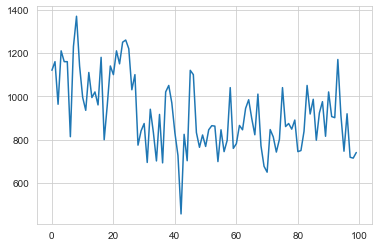

In [11]:
nile_df = sm.datasets.nile.load_pandas()
nile_df.data['volume'].plot()

In [12]:
nile_df.data.shape

(100, 2)

In [13]:
nile_df.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    100 non-null    float64
 1   volume  100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


In [14]:
# Stationarity check 
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(nile_df.data.volume,autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','# Observations'])
print(dfoutput)

Test Statistic    -4.048705
p-value            0.001176
#lags used         1.000000
# Observations    98.000000
dtype: float64


#### Since p is less than 0.05, we reject the null hypothesis that the root = 1. The series is Stationary. 

#### Splitting the data into train and test sets in a 90-10 split. 

In [21]:
train_ts = nile_df.data[0:90]
test_ts = nile_df.data[90:]

In [22]:
train_ts.shape

(90, 2)

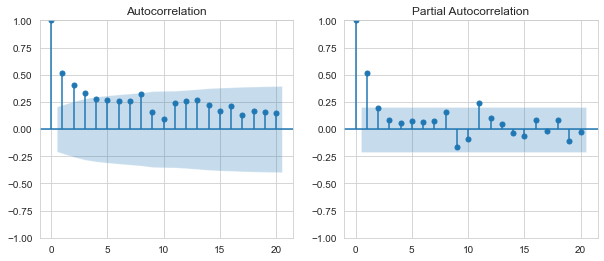

In [23]:
#Check for AutoCorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2, figsize=(10, 4))  #To make the chart a bit wider

plot_acf(train_ts.volume, ax=ax[0])
plot_pacf(train_ts.volume, method='ywm', ax=ax[1])
plt.show()

#### The PACF suggests the order 1 for AR but no specific order for MA. Hence we would keep the MA term as zero for now.

In [24]:
from statsmodels.tsa.arima.model import ARIMA

# fit model
series = train_ts.volume
model = ARIMA(series, order=(1,0,0)) # p = 1 based on the PACF plot and d = 0 since the data is stationary
ar_model = model.fit()

# summary of fit model
print(ar_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 volume   No. Observations:                   90
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -576.049
Date:                Sun, 27 Nov 2022   AIC                           1158.099
Time:                        13:11:13   BIC                           1165.598
Sample:                             0   HQIC                          1161.123
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        924.3224     31.488     29.355      0.000     862.607     986.038
ar.L1          0.5205      0.088      5.930      0.000       0.348       0.693
sigma2      2.108e+04   3549.962      5.938      0.0

#### Model Diagnostics via Residual Analysis

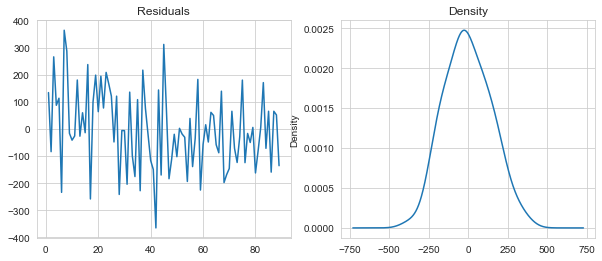

In [26]:
import matplotlib.pyplot as plt
residuals = ar_model.resid[1:]
fig, ax = plt.subplots(1,2, figsize=(10, 4))
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

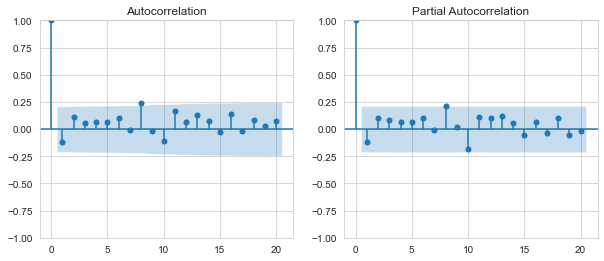

In [33]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))  

plot_acf(residuals, ax=ax[0])
plot_pacf(residuals, method='ywm', ax=ax[1])
plt.show()

#### There is no autocorrelation but the residual plot suggests seasonality. Re-evaulating orders via AutoARIMA

In [37]:
from pmdarima.arima import auto_arima

In [39]:
series = train_ts.volume

auto_ar_model = auto_arima(series, start_p=1, start_q=0,
                      test='adf',
                      max_p=7, max_q=3,
                      m=1,                   #non-seasonal
                      d=0,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1183.378, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1489.649, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1396.653, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1160.308, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1158.379, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1160.142, Time=0.31 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1160.207, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1159.095, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1158.294, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1154.982, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1167.887, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1158.0

#### Auto ARIMA suggests that an additional MA term is also included. Conducting Model Diagnostics again on the new model via SM. 

In [49]:
series = train_ts.volume

ar_model_updated = ARIMA(series, order = (1,0,1)).fit()


In [56]:
print(ar_model_updated.summary())

                               SARIMAX Results                                
Dep. Variable:                 volume   No. Observations:                   90
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -573.491
Date:                Sun, 27 Nov 2022   AIC                           1154.982
Time:                        14:04:25   BIC                           1164.981
Sample:                             0   HQIC                          1159.014
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        932.0252     50.112     18.599      0.000     833.807    1030.243
ar.L1          0.8655      0.082     10.589      0.000       0.705       1.026
ma.L1         -0.5258      0.149     -3.535      0.0

<AxesSubplot:title={'center':'Resid KDE Plot'}, ylabel='Density'>

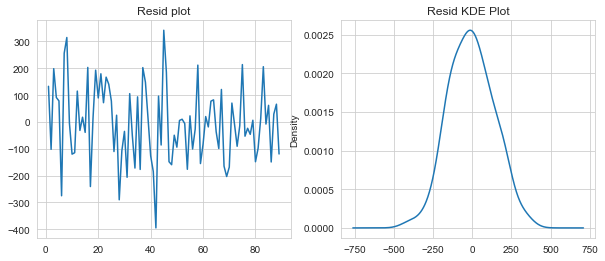

In [51]:
auto_resid = ar_model_updated.resid[1:]

fig, ax = plt.subplots(1,2, figsize = (10,4))

auto_resid.plot(title = 'Resid plot', ax = ax[0])
auto_resid.plot(title = 'Resid KDE Plot', kind = 'kde', ax = ax[1])

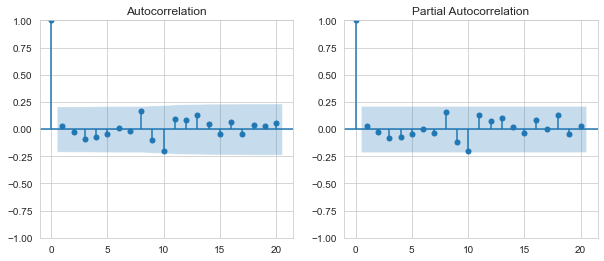

In [52]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))  

plot_acf(auto_resid, ax=ax[0])
plot_pacf(auto_resid, method='ywm', ax=ax[1])
plt.show()

#### The autocorrelation in the ACF and PACF plots for residuals is gone completely, but the residual plots still suggest seasonality. Hence adding a differencing order and retraining the model

In [53]:
series = train_ts.volume

ar_model_updated_1 = ARIMA(series, order = (1,1,1)).fit() # Adding a single order for differencing

In [57]:
print(ar_model_updated_1.summary())

                               SARIMAX Results                                
Dep. Variable:                 volume   No. Observations:                   90
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -566.859
Date:                Sun, 27 Nov 2022   AIC                           1139.718
Time:                        14:04:46   BIC                           1147.183
Sample:                             0   HQIC                          1142.727
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2594      0.133      1.947      0.052      -0.002       0.521
ma.L1         -0.8734      0.057    -15.260      0.000      -0.986      -0.761
sigma2      1.973e+04   2910.789      6.777      0.0

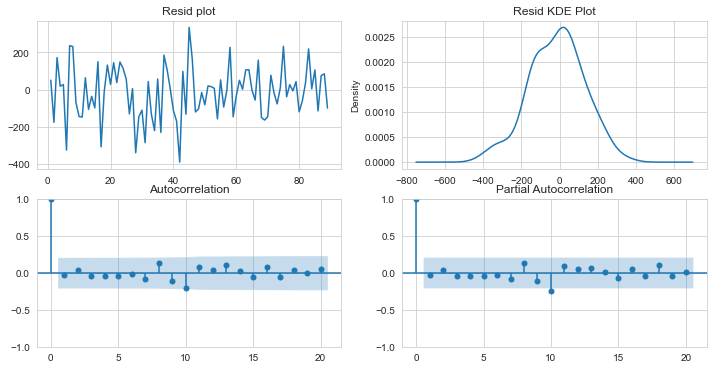

In [59]:
auto_resid = ar_model_updated_1.resid[1:]

fig, ax = plt.subplots(2,2, figsize = (12,6))

auto_resid.plot(title = 'Resid plot', ax = ax[0][0])
auto_resid.plot(title = 'Resid KDE Plot', kind = 'kde', ax = ax[0][1])
plot_acf(auto_resid, ax=ax[1][0])
plot_pacf(auto_resid, method='ywm', ax=ax[1][1])
plt.show()

#### The one order for differencing has some impact. The AIC for ARIMA(1,1,1) , 1139 is less than the AIC for ARIMA (1,0,1), 1154. but AR lag 1 is not significant. Adding the differencing will make us ignore the AR1 term. Even the KDE plot seems skewed.                Hence we will continue with ARIMA(1,0,1).

#### We will also add a seasonal component

In [95]:
series = train_ts.volume

sa_model = auto_arima(series, start_p=1, start_q=1,
                      max_p = 6,  max_q = 6,
                      test='adf',
                      d=0, D=0, m=7,
                      start_P=0, start_Q=0,
                      max_P=7, max_Q=7,
                      seasonal=True,   
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=1154.982, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=1184.318, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=1160.057, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=1168.785, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1489.649, Time=0.00 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=1159.081, Time=0.32 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=1158.906, Time=0.21 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=1158.708, Time=0.44 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=1167.887, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=1158.098, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=1158.294, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=1158.679, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[7] intercept   : AIC=1162.770, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=1156.566, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept

In [96]:
print(sa_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   90
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -573.491
Date:                Sun, 27 Nov 2022   AIC                           1154.982
Time:                        15:32:29   BIC                           1164.981
Sample:                             0   HQIC                          1159.014
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    125.3252     77.553      1.616      0.106     -26.675     277.326
ar.L1          0.8655      0.082     10.587      0.000       0.705       1.026
ma.L1         -0.5257      0.149     -3.535      0.0

### Comparing the forecast with the actual

In [81]:
ts_model_output = ar_model_updated.forecast(91)

In [89]:
ts_model_output_1 = ts_model_output.loc[90:100]

<AxesSubplot:>

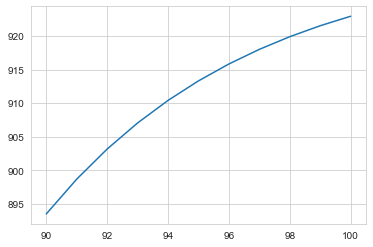

In [97]:
ts_model_output_1.plot()

In [99]:
ts_model_output_0 = ar_model_updated.forecast(91).loc[90:100]

In [100]:
ts_model_output_0

90     893.503193
91     898.682552
92     903.165536
93     907.045775
94     910.404308
95     913.311280
96     915.827405
97     918.005231
98     919.890245
99     921.521814
100    922.934017
Name: predicted_mean, dtype: float64

<AxesSubplot:>

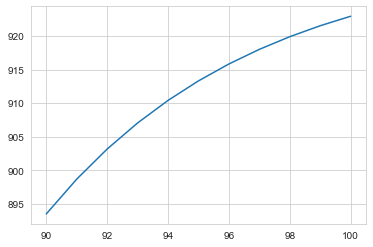

In [101]:
ts_model_output_0.plot()

<AxesSubplot:>

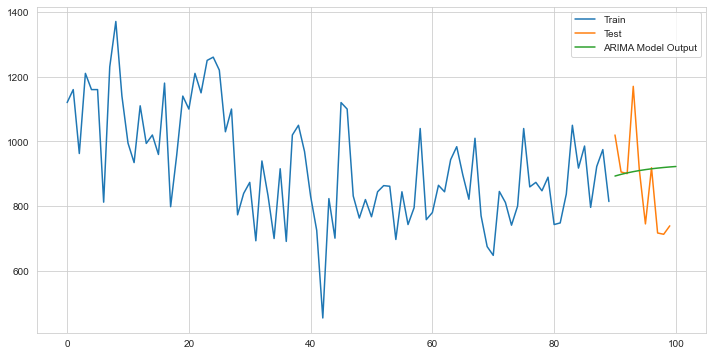

In [91]:
fig,ax = plt.subplots(1, figsize = (12,6))

train_ts.volume.plot(legend = True, label = 'Train', ax = ax )
test_ts.volume.plot(legend = True, label = 'Test', ax = ax)
ts_model_output_1.plot(legend = True, label='ARIMA Model Output', ax = ax)

#### Since we can observe that ARIMA models (both with the AR and AR + MA terms) are not matching with the test data, we will attempt the Exponential Smoothing methods. 

In [108]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

import matplotlib as mpl
mpl.rc("figure", figsize=(10,8))
import matplotlib.pyplot as plt
import seaborn as sns

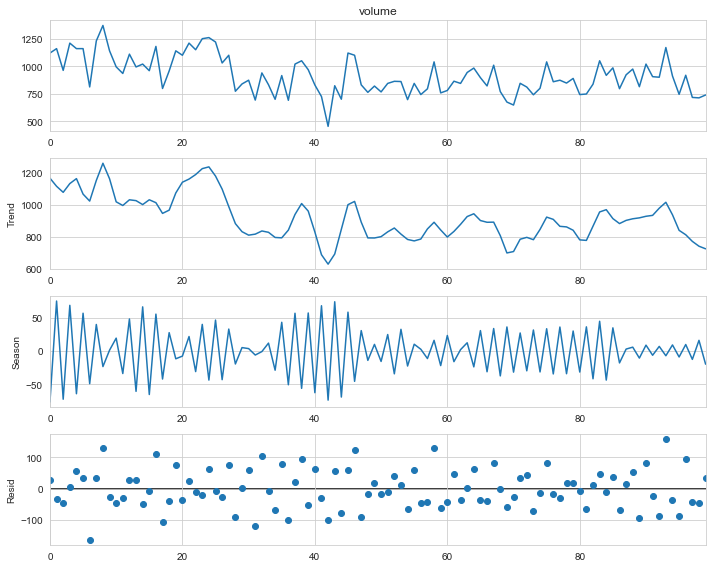

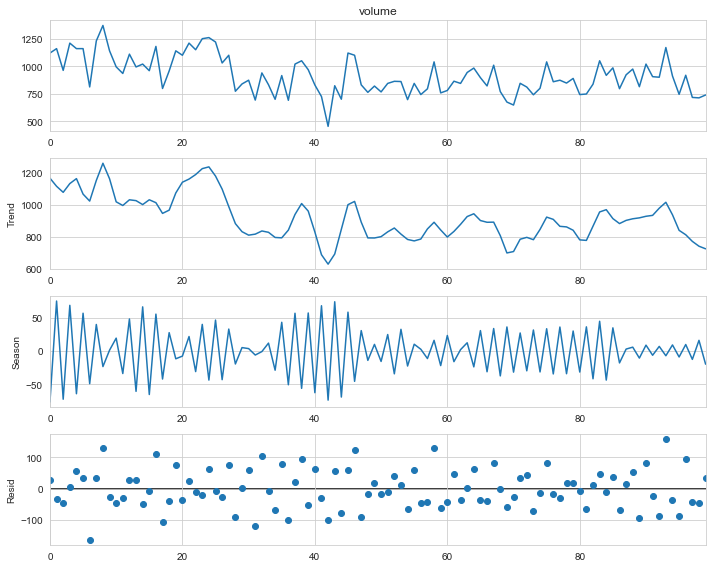

In [113]:
series = nile_df.data

stl_nileflow = STL(series.volume, period = 2).fit()

stl_nileflow.plot()

In [114]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing          # Simple 
from statsmodels.tsa.holtwinters import Holt                        # Holt's Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing        # Holt Winter's Exponential Smoothing

In [115]:
SE_fit = SimpleExpSmoothing(series.volume).fit()
Holt_fit = Holt(series.volume).fit()
HW_fit = ExponentialSmoothing(series.volume).fit()

In [119]:
# We shif the fitted values by -1

nile_df.data['SES'] = SE_fit.fittedvalues.shift(-1)
nile_df.data['holts'] = Holt_fit.fittedvalues.shift(-1)
nile_df.data['holt_winters'] = HW_fit.fittedvalues.shift(-1)

In [120]:
nile_df.data.head()

,year,volume,SES,holts,holt_winters
0,1871.0,1120.0,1113.022064,1113.067779,1113.021145
1,1872.0,1160.0,1124.566030,1129.654649,1124.565170
2,1873.0,963.0,1084.864140,1052.535200,1084.864068
3,1874.0,1210.0,1115.613984,1114.827253,1115.613482
4,1875.0,1160.0,1126.521034,1131.733666,1126.520497


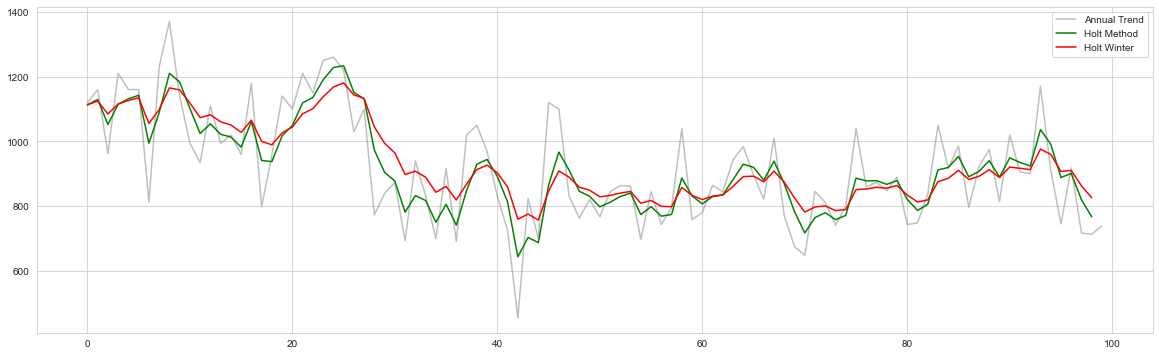

In [129]:
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(nile_df.data.volume, color='.5', alpha=.5, label='Annual Trend')
#ax.plot(nile_df.data['SES'], color='b', label='Exp Smoothing')
ax.plot(nile_df.data['holts'], color='g', label='Holt Method')
ax.plot(nile_df.data['holt_winters'], color='r', label='Holt Winter')
ax.legend()

#### Based on the above, we can observe that neither of the smoothing methods are overlapping with the data. Among Holt and Holt Winter, Holt seems to be giving closer results to the actual data. We can attempt tuning the Holt's method model

In [131]:
print(Holt_fit.summary())

                              Holt Model Results                              
Dep. Variable:                 volume   No. Observations:                  100
Model:                           Holt   SSE                        2188208.144
Optimized:                       True   AIC                           1007.342
Trend:                       Additive   BIC                           1017.763
Seasonal:                        None   AICC                          1008.246
Seasonal Periods:                None   Date:                 Sun, 27 Nov 2022
Box-Cox:                        False   Time:                         16:08:03
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.4159289                alpha                 True
smoothing_trend            0.0702483                

#### Empirically also, the AIC value for the base Holt model is 1007, in comparision to the ARIMA model AIC i.e. 1154. Hence we would proceed with Holt's method based on visual observation and AIC, and continue to fine tune the same.

In [142]:
Holt_fit_2 = Holt(train_ts.volume, initialization_method= 'known', initial_level=1120.0, initial_trend=1168.681305).fit()

# Initial level and trend retrieved from the stl decompose method

In [143]:
Holt_fit_2.summary()

Dep. Variable:,volume,No. Observations:,90
Model:,Holt,SSE,3644349.746
Optimized:,True,AIC,962.799
Trend:,Additive,BIC,972.798
Seasonal:,None,AICC,963.811
Seasonal Periods:,None,Date:,"Sun, 27 Nov 2022"
Box-Cox:,False,Time:,16:21:12
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8045889,alpha,True
smoothing_trend,0.5904594,beta,True


#### Thus we can observe that the AIC value is lower after tuning the parameters. Checking via visualization

In [148]:
Holt_fit_2_output = Holt_fit_2.fittedvalues.shift(-1)

<AxesSubplot:>

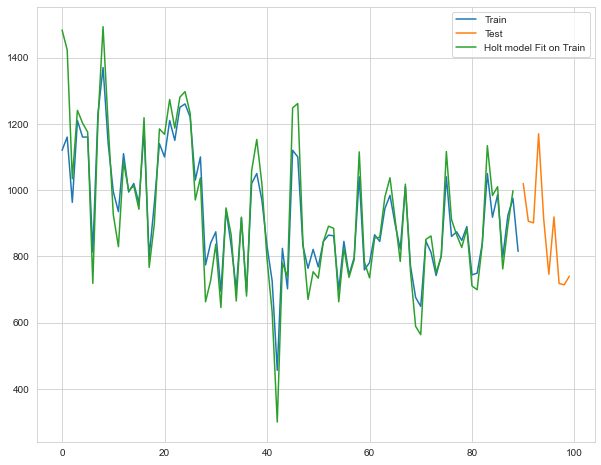

In [159]:
train_ts.volume.plot(legend = True, label = 'Train')
test_ts.volume.plot(legend = True, label = 'Test')
Holt_fit_2_output.plot(legend = True, label='Holt model Fit on Train')

In [160]:
Holt_fit_2_forecast = Holt_fit_2.forecast(90).rename('HW Forecast').loc[90:99]

<AxesSubplot:>

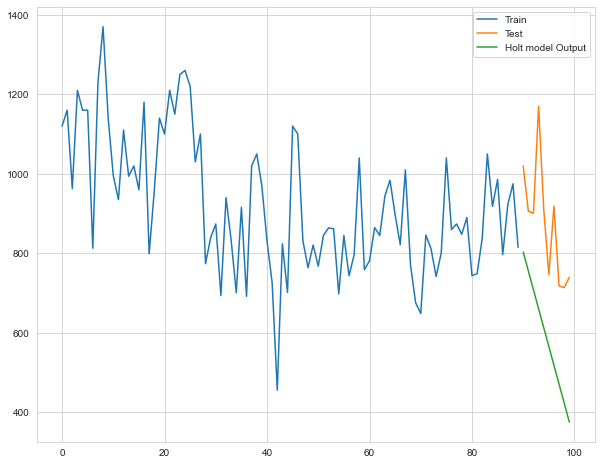

In [161]:
train_ts.volume.plot(legend = True, label = 'Train')
test_ts.volume.plot(legend = True, label = 'Test')
Holt_fit_2_forecast.plot(legend = True, label='Holt model Output')

#### The holt Method output is not fitting with the test data. It could be that Holt Winters should have been chosen in spite of holt method giving better results on the original data, since Holt Winters takes seasonality into account. We will attempt the solution via the Holt Winter's method

In [209]:
ts_model_hw = ExponentialSmoothing(train_ts.volume,
                                  trend = 'add',
                                  seasonal = 'add',
                                  seasonal_periods = 7).fit()

In [210]:
print(ts_model_hw.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                   volume   No. Observations:                   90
Model:             ExponentialSmoothing   SSE                        1846196.226
Optimized:                         True   AIC                            915.595
Trend:                         Additive   BIC                            943.092
Seasonal:                      Additive   AICC                           920.384
Seasonal Periods:                     7   Date:                 Sun, 27 Nov 2022
Box-Cox:                          False   Time:                         16:49:46
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2220316                alpha                 True
smoothing_trend          

In [211]:
ts_model_hw_forecast = ts_model_hw.forecast(91).loc[90:99]

<AxesSubplot:>

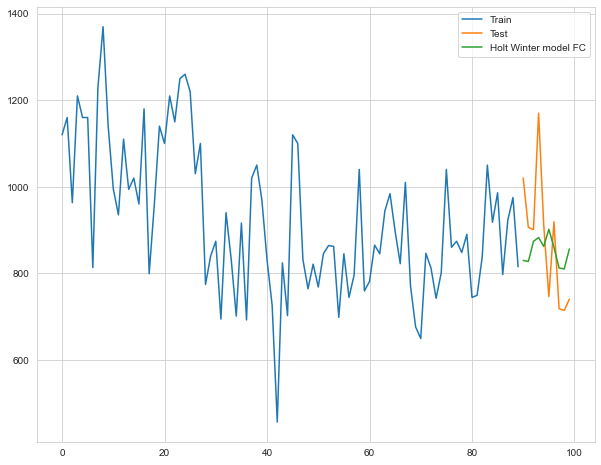

In [212]:
train_ts.volume.plot(legend = True, label = 'Train')
test_ts.volume.plot(legend = True, label = 'Test')
ts_model_hw_forecast.plot(legend = True, label='Holt Winter model FC')

In [213]:
import math

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [215]:
mse = mean_squared_error( test_ts.volume, ts_model_hw_forecast)
rmse = math.sqrt(mse)

print('The RMSE for the model is', round(rmse,3))

The RMSE for the model is 136.946


In [216]:
MAPE = mean_absolute_percentage_error( test_ts.volume, ts_model_hw_forecast)

print('The MAPE for the model is', round(MAPE,3))

The MAPE for the model is 0.13


In [222]:
nile_df.data['naive'] = nile_df.data.volume.shift(7)

In [225]:
test_ts_naive = nile_df.data.naive.loc[90:99]

In [226]:
MAPE = mean_absolute_percentage_error( test_ts.volume, test_ts_naive)

print('The MAPE for the Naive forecast is', round(MAPE,3))

The MAPE for the Naive forecast is 0.18


#### Thus, based on visual fitting and MAPE, we will recommend the Holt Winter's model